In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import sys
import matplotlib.pyplot as plt
import scipy.linalg.interpolative as sli
from scipy.io import loadmat



sys.path.append("../")
downsample_ratio = 2
n_train = 1000
n_test = 500


###################################
# load data
###################################
data_path = "../data/darcy_2d/piececonst_r421_N1024_smooth1"
data1 = loadmat(data_path)
data_path = "../data/darcy_2d/piececonst_r421_N1024_smooth2"
data2 = loadmat(data_path)
data_in = np.vstack((data1["coeff"], data2["coeff"]))  # shape: 2048,421,421
data_out = np.vstack((data1["sol"], data2["sol"]))     # shape: 2048,421,421
print("data_in.shape:" , data_in.shape)
print("data_out.shape", data_out.shape)








data_in.shape: (2048, 421, 421)
data_out.shape (2048, 421, 421)


In [4]:
Np_ref = data_in.shape[1]
L=1.0
grid_1d = np.linspace(0, L, Np_ref)
grid_x, grid_y = np.meshgrid(grid_1d, grid_1d)

data_in_ds = data_in[:, 0::downsample_ratio, 0::downsample_ratio].astype(float)
grid_x_ds = grid_x[0::downsample_ratio, 0::downsample_ratio]
grid_y_ds = grid_y[0::downsample_ratio, 0::downsample_ratio]
data_out_ds = data_out[:, 0::downsample_ratio, 0::downsample_ratio]


x_train = data_in_ds[0:n_train,:,:].reshape(n_train, -1)   
y_train = data_out_ds[0:n_train,:,:].reshape(n_train, -1)

x_test = data_in_ds[-n_test:,:,:].reshape(n_test, -1)   
y_test = data_out_ds[-n_test:,:,:].reshape(n_test, -1)
print("x_train.shape: ",x_train.shape)
print("y_train.shape: ",y_train.shape)


x_train.shape:  (1000, 44521)
y_train.shape:  (1000, 44521)


# Linear Model
Given input bases $X_b \in R^{k_{in} \times N}$ and output bases $Y_b \in R^{k_{out}\times N}$, we will find a linear map $K\in R^{k_{out}\times k_{in}}$

$$ x^T X_b^T K Y_b  = y^T $$


We have $n$ training data pairs $\{x_i, y_i\}_{i=1}^n$, and solve for $K$ by minimizing

$$\sum_{i=1}^n \lVert y_i^T - x_i^T X_b^T K Y_b \rVert \textrm{ or }  \sum_{i=1}^n \lVert \frac{y_i^T}{\lVert y_i \rVert} - \frac{x_i^T}{\lVert y_i \rVert} X_b^T K Y_b \rVert$$

with penalization terms. By defining $X \in R^{n \times N}$ and $Y \in R^{n \times N}$, we can solve for $K$ by minimizing 

$$\min \lVert X X_b^T K Y_b  - Y \rVert  \textrm{ or }  \lVert \frac{X}{D} X_b^T K Y_b  - \frac{Y}{D} \rVert$$

here $D = \textrm{diag}{\lVert y_1\rVert,\lVert y_2\rVert,\cdots \lVert y_n\rVert}$


We can construct orthogonal bases 

$$ Y_b = K_y \hat{Y}_b $$

We have 

$$x^T X_b^T (K K_y) \hat{Y}_b  = y^T$$ 

And we can define $\hat{K} = K K_y $. 

In [116]:
def compute_2dFourier_modes(k):
    trunc_k = np.int64(np.sqrt(k)) + 1

    k_pairs = np.zeros(((2 * trunc_k + 1) ** 2, 2))
    k_pair_mag = np.zeros((2 * trunc_k + 1) ** 2)

    i = 0
    for kx in range(-trunc_k, trunc_k + 1):
        for ky in range(-trunc_k, trunc_k + 1):

            k_pairs[i, :] = kx, ky
            k_pair_mag[i] = kx**2 + ky**2
            i += 1

    k_pairs = k_pairs[np.argsort(k_pair_mag), :]
    return k_pairs[0:k, :]

def compute_2dFourier_bases(gridx, gridy, k):
    Lx = Ly = 1.0
    nx, ny = gridx.shape
    
  
    bases = np.zeros((k, nx, ny))
    k_pairs = compute_2dFourier_modes(k)
    for i in range(k):
        kx, ky = k_pairs[i, :]
        if kx == 0 and ky == 0:
            bases[i, :, :] = np.sqrt(1 / (Lx * Ly))
        elif ky > 0 or ky == 0 and kx > 0:
            bases[i, :, :] = np.sqrt(2 / (Lx * Ly)) * np.sin(
                2 * np.pi * (kx * gridx / Lx + ky * gridy / Ly)
            )
        else:
            bases[i, :, :] = np.sqrt(2 / (Lx * Ly)) * np.cos(
                2 * np.pi * (kx * gridx / Lx + ky * gridy / Ly)
            )
    return bases





def linear_model(x_train, y_train, x_bases, y_bases):
    N,  n = x_train.shape
    _, nx = x_bases.shape
    _, ny = y_bases.shape
    

    Uy, Dy, VyT = np.linalg.svd(y_bases, full_matrices=False)
    
    D = np.linalg.norm(y_train, axis=1)
    
    K_hat, res, _, _ = np.linalg.lstsq(x_train / D[:, np.newaxis]  @ x_bases.T, y_train / D[:, np.newaxis]  @ VyT.T)  
     
    K = K_hat / Dy @ Uy.T
    
    
    print("linear model error: ", np.average(np.linalg.norm(x_train @ x_bases.T @ K @ y_bases - y_train, axis=1)/np.linalg.norm(y_train, axis=1))  )
    
    
    return K

def linear_model_pred(x_train, y_train, x_bases, y_bases):

    fig, axs = plt.subplots(1, 2, figsize=(6,3))
    axs[0].pcolormesh(grid_x_ds, grid_y_ds, x_bases[0,:].reshape(grid_x_ds.shape))
    axs[1].pcolormesh(grid_x_ds, grid_y_ds, y_bases[0,:].reshape(grid_x_ds.shape))
    fig.suptitle("input output bases")


    K = linear_model(x_train, y_train, x_bases, y_bases)

    y_train_rec = x_train @ x_bases.T @ K @ y_bases
    y_test_rec  = x_test @ x_bases.T @ K @ y_bases

    print("rel. y_train reconstruction error = ", np.average(np.linalg.norm(y_train_rec - y_train, axis=1)/np.linalg.norm(y_train, axis=1)))
    print("rel. y_test reconstruction error = ", np.average(np.linalg.norm(y_test_rec - y_test, axis=1)/np.linalg.norm(y_test, axis=1)))

    fig, axs = plt.subplots(2, 3, figsize=(12, 6))

    idx = 0
    quad = axs[0,0].pcolormesh(grid_x_ds, grid_y_ds, y_train[idx, :].reshape(grid_x_ds.shape))
    fig.colorbar(quad, ax=axs[0,0])
    axs[0,1].pcolormesh(grid_x_ds, grid_y_ds, y_train_rec[idx, :].reshape(grid_x_ds.shape))
    fig.colorbar(quad, ax=axs[0,1])
    quad = axs[0,2].pcolormesh(grid_x_ds, grid_y_ds, (y_train[idx, :] - y_train_rec[idx, :]).reshape(grid_x_ds.shape))
    fig.colorbar(quad, ax=axs[0,2])


    quad = axs[1,0].pcolormesh(grid_x_ds, grid_y_ds, y_test[idx, :].reshape(grid_x_ds.shape))
    fig.colorbar(quad, ax=axs[1,0])
    axs[1,1].pcolormesh(grid_x_ds, grid_y_ds, y_test_rec[idx, :].reshape(grid_x_ds.shape))
    fig.colorbar(quad, ax=axs[1,1])
    quad = axs[1,2].pcolormesh(grid_x_ds, grid_y_ds, (y_test[idx, :] - y_test_rec[idx, :]).reshape(grid_x_ds.shape))
    fig.colorbar(quad, ax=axs[1,2])
    
    fig.suptitle("Reference and Prediction")


# PCA bases

In [114]:
x_k_max = 1000
U, S, VT = np.linalg.svd(x_train, full_matrices=False)
x_bases = VT[0:x_k_max, :]
y_k_max = 128
U, S, VT = np.linalg.svd(y_train, full_matrices=False)
y_bases = VT[0:y_k_max, :]

/var/folders/ch/c01gr5_d0jbbqhb3qh06_vn40000gn/T/ipykernel_23480/4151025043.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  K_hat, res, _, _ = np.linalg.lstsq(x_train / D[:, np.newaxis]  @ x_bases.T, y_train / D[:, np.newaxis]  @ VyT.T)


linear model error:  0.007414671469424797
rel. y_train reconstruction error =  0.007414671469424797
rel. y_test reconstruction error =  0.16586553781726918


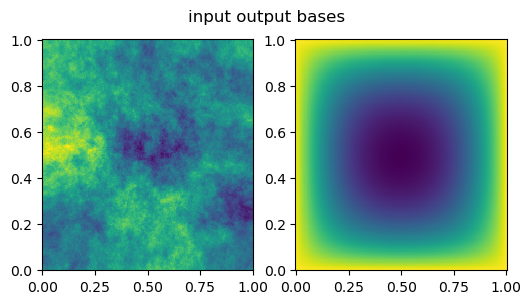

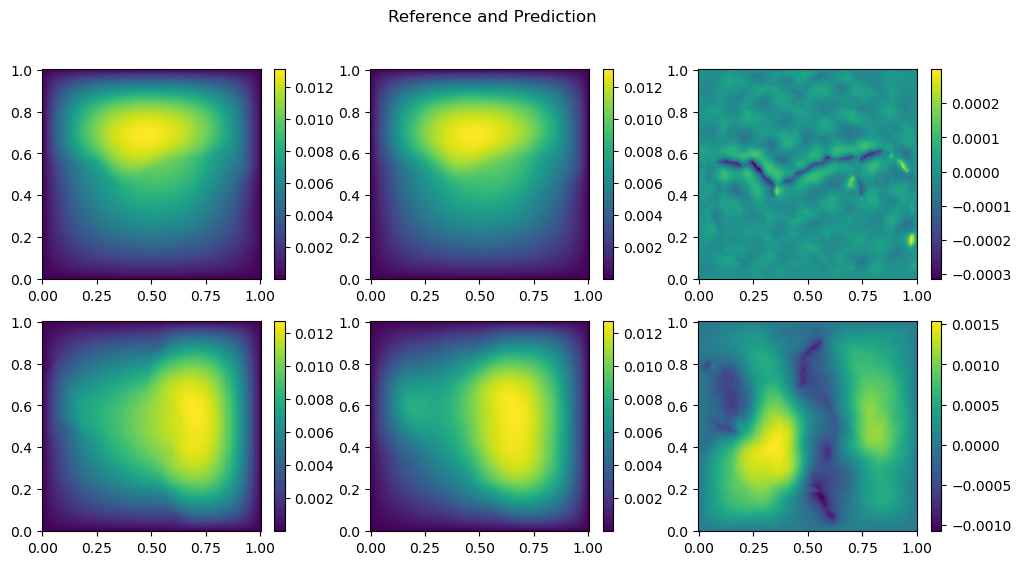

In [115]:
linear_model_pred(x_train, y_train, x_bases, y_bases)

# Fourier bases

/var/folders/ch/c01gr5_d0jbbqhb3qh06_vn40000gn/T/ipykernel_23480/4187670747.py:53: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  K_hat, res, _, _ = np.linalg.lstsq(x_train / D[:, np.newaxis]  @ x_bases.T, y_train / D[:, np.newaxis]  @ VyT.T)


linear model error:  0.10227403260797249
rel. y_train reconstruction error =  0.10227403260797249
rel. y_test reconstruction error =  0.1999768669533051


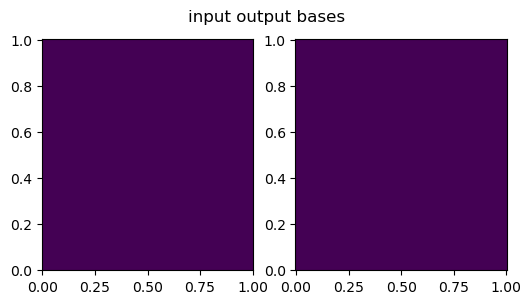

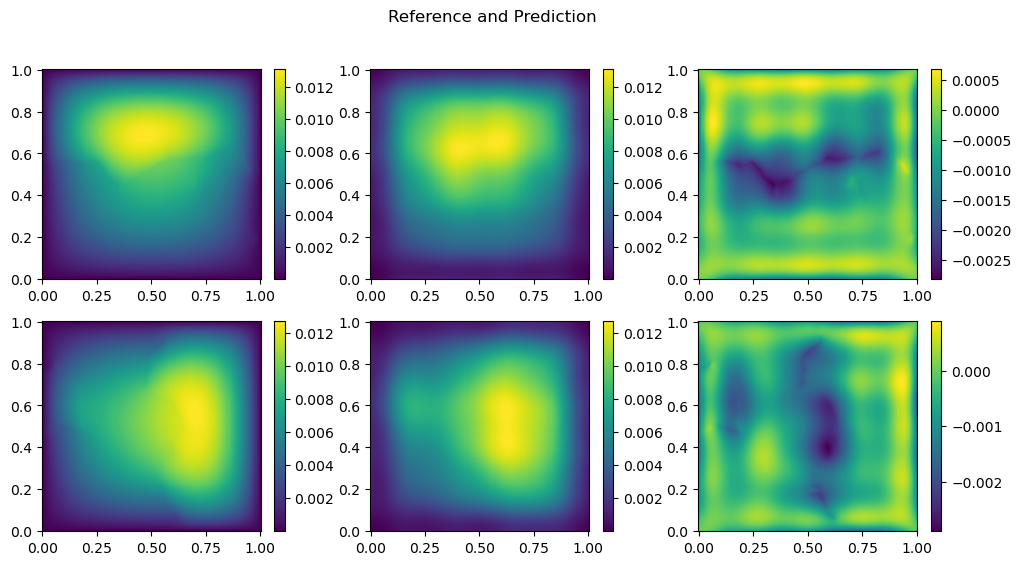

In [120]:
k = 1000
bases = compute_2dFourier_bases(grid_x_ds, grid_y_ds, k)

x_k_max = 512
x_bases = bases.reshape((k,-1))[0:x_k_max, :]
y_k_max = 64
y_bases = bases.reshape((k,-1))[0:y_k_max, :]

linear_model_pred(x_train, y_train, x_bases, y_bases)

# Column Selection Bases

/var/folders/ch/c01gr5_d0jbbqhb3qh06_vn40000gn/T/ipykernel_23480/4187670747.py:53: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  K_hat, res, _, _ = np.linalg.lstsq(x_train / D[:, np.newaxis]  @ x_bases.T, y_train / D[:, np.newaxis]  @ VyT.T)


linear model error:  0.08912139446969121
rel. y_train reconstruction error =  0.08912139446969121
rel. y_test reconstruction error =  0.15501738688865796


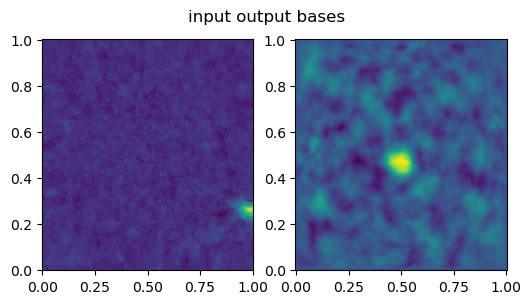

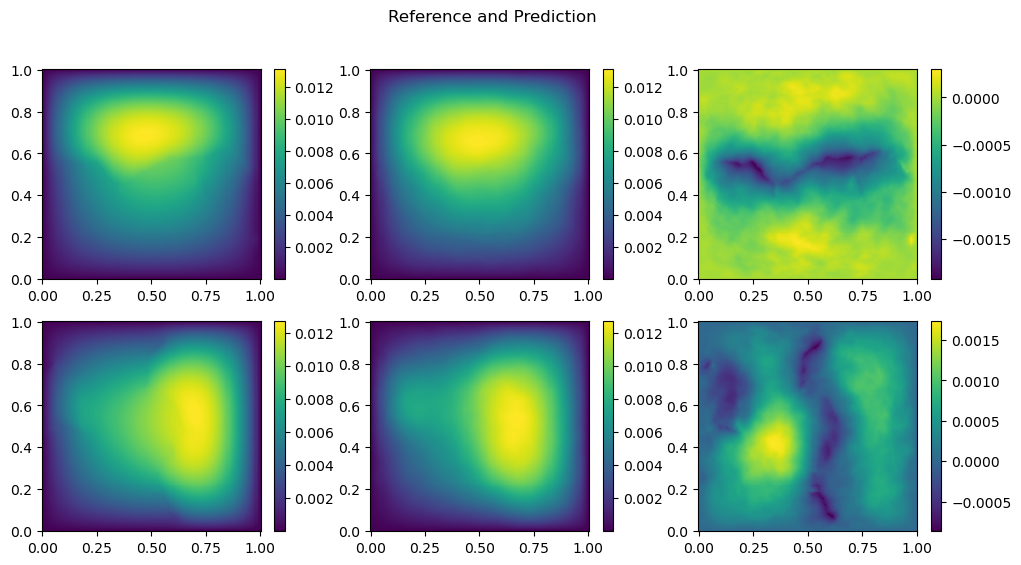

In [130]:
import scipy.linalg.interpolative as sli

x_k_max = 512
x_idx, x_proj = sli.interp_decomp(x_train, x_k_max)
x_bases = np.hstack([np.eye(x_k_max), x_proj])[:,np.argsort(x_idx)]
                                   
y_k_max = 128
y_idx, y_proj = sli.interp_decomp(y_train, y_k_max)
y_bases = np.hstack([np.eye(y_k_max), y_proj])[:,np.argsort(y_idx)]
    


linear_model_pred(x_train, y_train, x_bases, y_bases)